In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import joblib

import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings
from IPython.display import display, HTML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import shap 
import lime# SHAP for explainability
from lime.lime_tabular import LimeTabularExplainer  # LIME for local explanations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf





# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt) #ensures any changes made to matplotlib.pyplot during the session are applied.
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

c:\Users\tonya\Anaconda3\envs\fl_project_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv('dataset/train_edge_iiot.csv', low_memory=False)

In [9]:
df.shape

(1527736, 69)

In [3]:
df.shape

(1527736, 69)

In [4]:
print(df['Attack_type'].value_counts())

Attack_type
7     1091257
4       97283
2       54410
11      40541
3       40169
13      39977
8       39860
1       38878
12      29493
0       19281
9       15956
14      11922
10       7725
5         691
6         293
Name: count, dtype: int64


In [14]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Extract features and labels
X = df.drop(columns=['Attack_type','Attack_label']).values
y = df['Attack_type'].values

num_clients = 4
alpha = 0.5
classes = np.unique(y)
data_per_client = defaultdict(list)

# Dirichlet-based partitioning
for c in classes:
    idx = np.where(y == c)[0]
    np.random.shuffle(idx)
    proportions = np.random.dirichlet([alpha] * num_clients)
    proportions = (np.cumsum(proportions) * len(idx)).astype(int)[:-1]
    splits = np.split(idx, proportions)
    
    for client_id, data_idx in enumerate(splits):
        data_per_client[client_id].extend(data_idx)

# Build client datasets
client_datasets = {}
for client_id, indices in data_per_client.items():
    client_X = X[indices]
    client_y = y[indices]
    client_datasets[client_id] = (client_X, client_y)

    # Save to CSV
    client_df = pd.DataFrame(client_X, columns=df.drop(columns=['Attack_type','Attack_label']).columns)
    client_df['Attack_type'] = client_y
    client_df['Attack_label'] = df.loc[indices, 'Attack_label'].values
    client_df.to_csv(f'dataset/client_{client_id}_data.csv', index=False)
    print(f"Client {client_id} data saved with {len(client_y)} samples.")


Client 0 data saved with 255706 samples.
Client 1 data saved with 419992 samples.
Client 2 data saved with 186619 samples.
Client 3 data saved with 665419 samples.


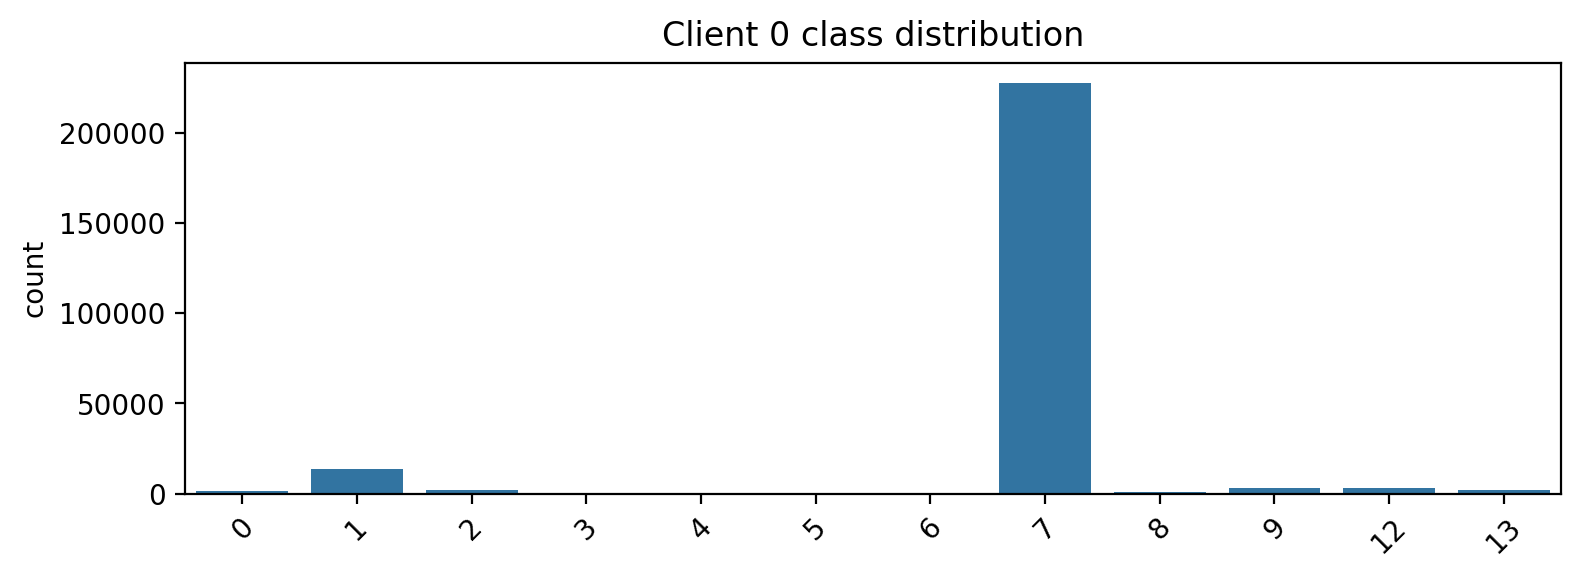

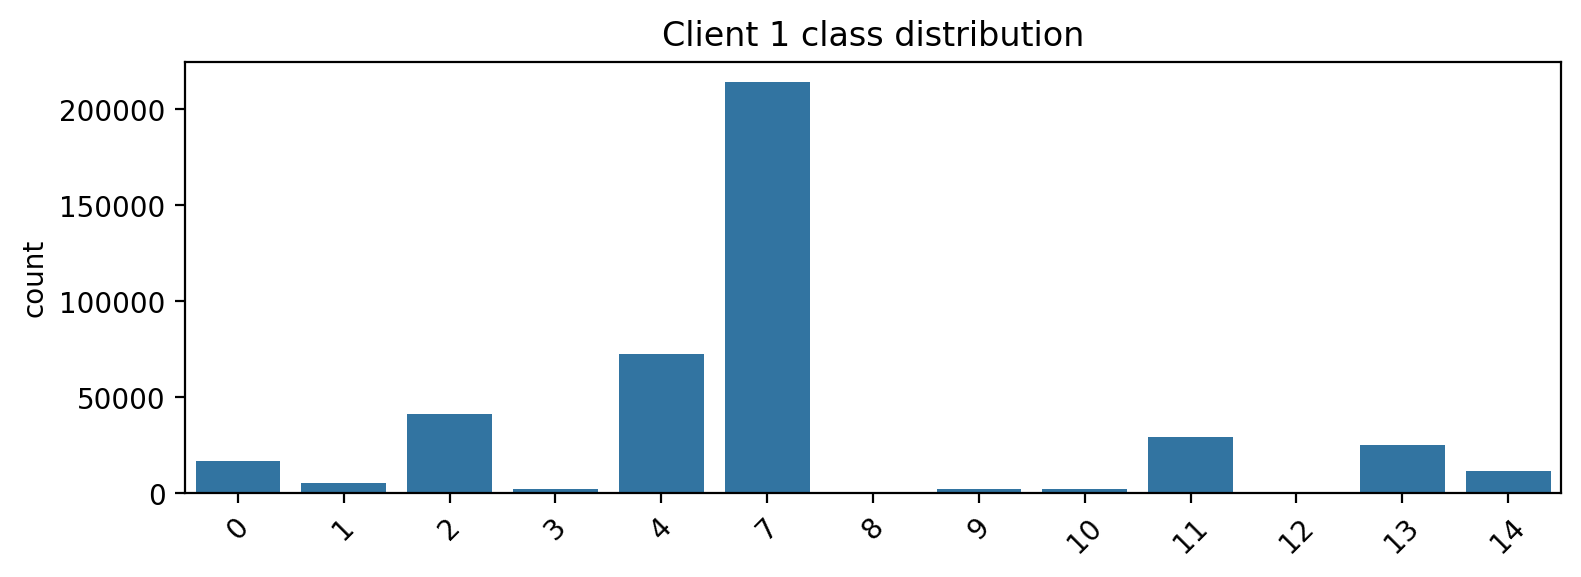

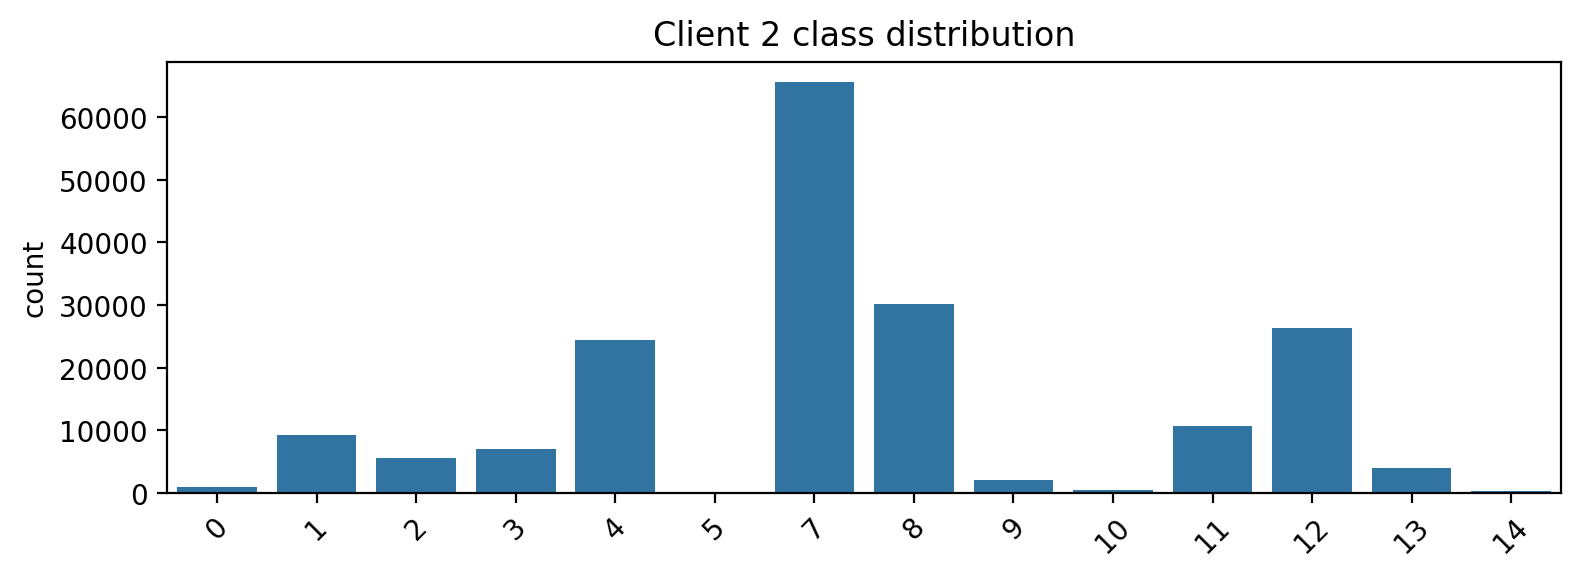

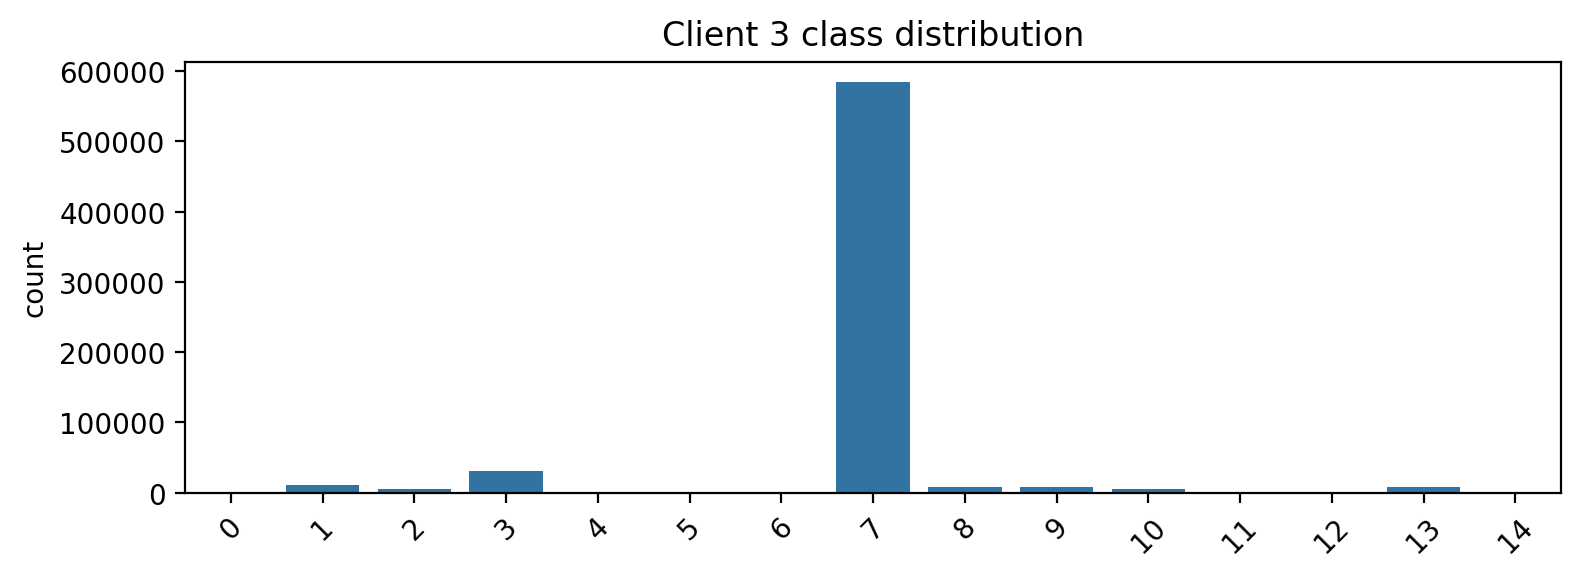

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

for client_id, (_, client_y) in client_datasets.items():
    plt.figure(figsize=(8, 3))
    sns.countplot(x=client_y)
    plt.title(f'Client {client_id} class distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()